# Analyzing Business Opportunities for The “Chinook” Online Music Store

## Introduction
>Throughout this project, we will be analyzing data based on an audio music streaming provider called "Chinook". The "Chinook" database contains information regarding music files such as artist, song, and album information. The database also contains information regarding employee and customer information. The aim of this project is to explore business opportunities available to Chinook through the exploration of its database. Specifically, we will be answering the following business questions:
> - Which genres sell the most in the USA?
> - How well has each customer support agent performed?
> - Which countries have the most sales?
> - Of the available artists genres, which genre performs the best?

In [3]:
#Importing the Relevant Libraries and the SQL Engine

import sqlalchemy
sqlalchemy.create_engine("sqlite:///foo.db")
%reload_ext sql
%sql sqlite:///chinook.db

'Connected: @chinook.db'

### Database Schema

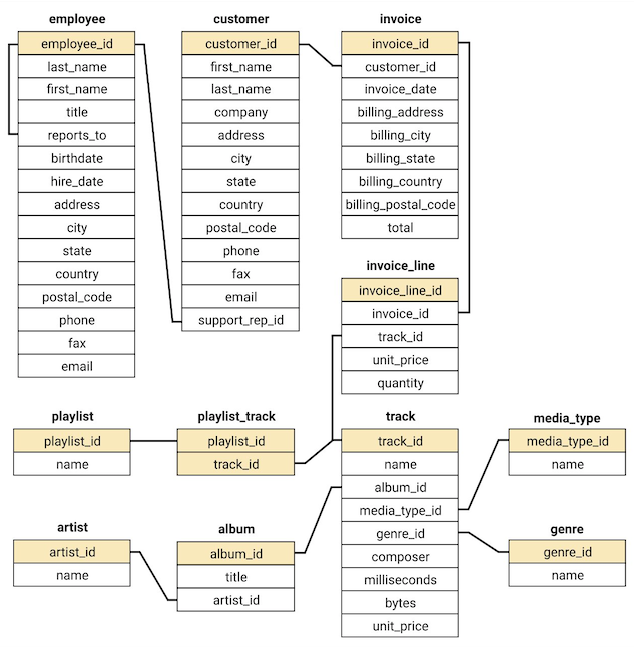

In [4]:
%%sql

SELECT name,
        type
FROM sqlite_master
WHERE type IN ("table", "view");

   sqlite:///SQL
 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


>Looking at the databse tables above, we can see that that we can group the tables into 3 categories, the 1st category continas tables regarding music files: "album", "artist", "genre", "playlist", "playlist_track", "track", "media_type", the 2nd category contains information regarding payments: "invoice", "invoice_line", and the last category contains information regarding personel: "employee", "customer".

### Of the available artists genres, which genre performs the best?

In [4]:
%%sql

WITH

customer_usa AS
(
SELECT *
FROM customer
WHERE country = "USA"
),

customer_usa_invoice_id AS
(
SELECT c.customer_id AS "customer_id",
        i.invoice_id AS "invoice_id"
FROM customer_usa AS c INNER JOIN invoice AS i ON c.customer_id = i.customer_id
),

genre_info AS
(
SELECT c.customer_id,
       il.invoice_id AS "invoice_id",
       il.unit_price AS "unit_price",
       il.quantity AS "quantity",
       il.track_id AS "track_id",
       t.genre_id AS "genre_id",
       g.name AS "genre_name"
FROM customer_usa_invoice_id AS c INNER JOIN invoice_line AS il ON c.invoice_id = il.invoice_id 
        INNER JOIN track AS t ON t.track_id = il.track_id INNER JOIN genre AS g ON g.genre_id = t.genre_id
)

SELECT genre_name AS "genre",
       COUNT(*) AS "tracks_sold",
       ROUND((COUNT(*) / CAST((SELECT COUNT(*) FROM genre_info) AS FLOAT)) * 100, 2) || "%" AS "percentage"
FROM genre_info
WHERE "genre" IN ("Hip Hop/Rap", "Alternative & Punk", "Pop", "Blues")
GROUP BY genre_name
ORDER BY "tracks_sold" DESC;

 * sqlite:///chinook.db
Done.


genre,tracks_sold,percentage
Alternative & Punk,130,12.37%
Blues,36,3.43%
Pop,22,2.09%
Hip Hop/Rap,20,1.9%


>Chinook received an opportunity to add a group of artists to its portfolio. They were only interested in adding one of the artists. The artists came from the 4 different genres: "Alternative & Punk", "Blue", "Pop", "Hip Hop/Rap". We were tasked with selecting the ideal artist to add to Chinook's portfolio of artists. The criteria for selecting the single artist was based on how popular the genre they sing/perform in was. Of the 4 genes, we can deduce that "Alternative & Punk" was the most popular, with 130 tracks belonging to the genre being sold, which is around 12.37% of total sales. The remaining genres were significantly less popular.

### How well has each customer support agent performed?

In [6]:
%%sql

WITH

customer_total_purchases AS
(
SELECT c.customer_id AS "customer_id",
       SUM(total) AS "total_purchased",
       c.support_rep_id AS "support_rep_id"
FROM invoice AS i INNER JOIN customer AS c ON i.customer_id = c.customer_id
GROUP BY c.customer_id
),

employee_customer_total_purchases AS
(
SELECT e.employee_id AS "employee_id",
       e.first_name || " " || e.last_name AS "employee_name",
       e.title AS "title",
       e.hire_date AS "hire_date",
       ctp.*
FROM employee AS e LEFT JOIN customer_total_purchases AS ctp ON e.employee_id = ctp.support_rep_id
)

SELECT employee_name AS "employee_name",
        SUM(total_purchased) AS "total_employee_revenue",
        (STRFTIME('%m',  DATE("now")) + 12*strftime('%Y', DATE("now"))) - 
        (STRFTIME('%m',  hire_date) + 12*strftime('%Y', hire_date)) AS "months_at_comp",
        SUM(total_purchased) /
        ((STRFTIME('%m',  DATE("now")) + 12*strftime('%Y', DATE("now"))) - 
        (STRFTIME('%m',  hire_date) + 12*strftime('%Y', hire_date))) AS "revenue_per_month"
FROM employee_customer_total_purchases
WHERE "title" = "Sales Support Agent"
GROUP BY employee_id;

 * sqlite:///chinook.db
Done.


employee_name,total_employee_revenue,months_at_comp,revenue_per_month
Jane Peacock,1731.51,56,30.919821428571428
Margaret Park,1584.0,55,28.8
Steve Johnson,1393.92,50,27.878400000000003


>We will be analyzing employee performance by calculating the dollar amount of sales each employee contributed towards the company since their commencement at Chinook. We can see that "Jane Peackcock” has produced the most revenue for Chinook since she first started with 1731.51 dollars worth of sales. However, to further highlight her stellar performance, we calculated her total sales in dollar amounts per month. We see that she outperforms "Margaret Park" and "Steve Johnson" by around 2 dollars on average. The difference between "Margaret Park" and "Steve John" is very minimal. However, if "Steve Johnson" improves his performance by at least 1 dollars per month, he will eventually outperform "Margaret Park" come his 55th month working at Chinook.

### Which countries have the most sales?

In [7]:
%%sql

WITH country_pop_1 AS
(
SELECT country AS "country",
       COUNT(*) AS "country_pop"
FROM customer
GROUP BY country
HAVING "country_pop" = 1
),

country_names_pop_1 AS
(
SELECT country AS "country"
FROM country_pop_1
),

new_countries AS
(
SELECT c.*,
       CASE
       WHEN c.country IN country_names_pop_1 THEN "Other"
       ELSE c.country
       END AS "new_country"
FROM customer AS c
),

new_countries_invoice AS
(
SELECT *
FROM new_countries AS nc INNER JOIN invoice AS i ON nc.customer_id = i.customer_id
),

customer_country_total AS
(
SELECT customer_id As "customer_id",
       new_country AS "country",
       SUM(total) AS "customer_total_purchased"
FROM new_countries_invoice
GROUP BY customer_id
),

final_table AS
(
SELECT cct.country AS "country",
       COUNT(*) AS "number_of_customers",
       SUM(customer_total_purchased) AS "total_sales",
       average_order AS "average_order",
       AVG(customer_total_purchased) AS "customer_lifetime_value"      
FROM customer_country_total AS cct INNER JOIN (SELECT new_country, 
         AVG(total) AS "average_order"
FROM new_countries_invoice
GROUP BY new_country) AS nt ON cct.country = nt.new_country
GROUP BY country
ORDER BY country = "Other", "number_of_customers" DESC
)

SELECT *
FROM final_table;

 * sqlite:///chinook.db
Done.


country,number_of_customers,total_sales,average_order,customer_lifetime_value
USA,13,1040.49,7.942671755725189,80.03769230769231
Canada,8,535.59,7.047236842105265,66.94875
Brazil,5,427.67999999999995,7.0111475409836075,85.53599999999999
France,5,389.07,7.781399999999998,77.814
Germany,4,334.62,8.161463414634147,83.655
United Kingdom,3,245.51999999999998,8.768571428571429,81.83999999999999
Czech Republic,2,273.24,9.108000000000002,136.62
India,2,183.14999999999998,8.72142857142857,91.57499999999999
Portugal,2,185.13,6.383793103448276,92.565
Other,15,1094.94,7.44857142857143,72.99600000000001


>As expected, we see the USA perform the best out of all the countries. The American music industry trumps other music industries around the world and it only makes sense that most customers come from the USA and spend their money at an American music store. We see that the USA has total sales of \\$1040, with an average order amount of $7.9. Although the USA does spend the most in total, we see other countries such as Germany have customers who spend more on order on average. This shows that when German customers visit the store with the intention to buy, they spend more than US customers in a single transaction. Notably, this statistic was generated from only 4 german customers, which is not a sample that is representative of all German customers, meaning that we should take these findings with a grain of salt.

In [10]:
%%sql

WITH

invoice_one_track AS
(
SELECT il.invoice_id AS "invoice_id",
       t.track_id AS "a_track",
       t.album_id AS "album_id"
FROM invoice_line AS il INNER JOIN track AS t ON il.track_id = t.track_id
GROUP BY invoice_id
)

SELECT  CASE
        WHEN
        ((SELECT t.track_id
          FROM track AS t
          WHERE t.album_id = iot.album_id
         
         EXCEPT
         
          SELECT il.track_id
          FROM invoice_line AS il
          WHERE il.invoice_id = iot.invoice_id) IS NULL
         
         AND
         
        ( SELECT il.track_id
          FROM invoice_line AS il
          WHERE il.invoice_id = iot.invoice_id
          
          EXCEPT
          
          SELECT t.track_id
          FROM track AS t
          WHERE t.album_id = iot.album_id) IS NULL) == FALSE THEN "A"
        
        ELSE "T"
        END AS "invoice_type",
        COUNT(*) AS "number_of_invoices",
        ROUND(COUNT(*) / CAST((SELECT COUNT(*) FROM invoice_one_track) AS FLOAT) * 100, 2) || "%" AS "percent"  
FROM invoice_one_track AS iot
GROUP BY "invoice_type";

 * sqlite:///chinook.db
Done.


invoice_type,number_of_invoices,percent
A,500,81.43%
T,114,18.57%


>Chinook Management is currently considering changing its purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. We have been tasked with finding out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue. As we can see above, album purchases account for around 18.6% of the total sales, which is still a significant portion. If they focus their strategy on only purchasing select albums they would risk losing one-fifth of their revenue. For this reason, they should continue purchasing whole albums.

## Conclusion
>From the artists available, Chinook should look to sign those that sing in the "Alternative & Punk" genre as the genre shows the most promising profit opportunities - 12.37% of the tracks sold were linked to this genre. The employee with the best performance was "Jane Peacock", contributing around 31 Dollars in sales per month. The remaining employees were also relatively performing well, contributing around 29 Dollars and 28 Dollars per month in sales since the commencement of their career. Customers from the United States are mostly represented in the database, accumulating 1040 Dollars in total sales. Lastly, Chinook should not change their purchasing strategy to solely buying select tracks as it could potentially lose one-fifth of its revenue.